# Data + DataLoaders (CIFAR 10)

Goal: set up CIFAR-10 with reproducible splits and transforms that play nicely with a VAE (images scaled to [-1, 1])

In [ ]:
# --- Step 1A: Imports & device/seed utils ---
import os, random, math, numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt

def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Faster (less reproducible) kernels:
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
                      else "cpu")

seed_everything(123)
print("Device:", device)



Device: cpu


In [ ]:
# --- Step 1B: CIFAR-10 transforms ---

img_size = 32
train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(img_size, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # => [-1, 1]
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [ ]:
# --- Step 1C: Dataset & loaders ---
data_root = "./data"
train_set = datasets.CIFAR10(root=data_root, train=True,  download=True, transform=train_tfms)
test_set  = datasets.CIFAR10(root=data_root, train=False, download=True, transform=test_tfms)

batch_size   = 128
num_workers  = min(8, os.cpu_count() or 2)
pin_mem      = (device.type == "cuda")

train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=pin_mem, drop_last=True,
    persistent_workers=(num_workers > 0), prefetch_factor=2
)
test_loader  = DataLoader(
    test_set, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=pin_mem, drop_last=False,
    persistent_workers=(num_workers > 0), prefetch_factor=2
)

len(train_set), len(test_set)


100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


(50000, 10000)

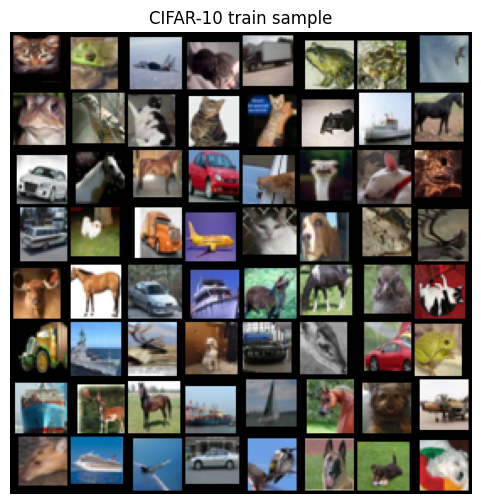

In [ ]:
# --- Step 1D: Sanity check a batch (denormalize for display) ---
def denorm(x):
    # x in [-1,1] -> [0,1]
    return (x + 1) / 2

imgs, labels = next(iter(train_loader))
grid = vutils.make_grid(denorm(imgs[:64]), nrow=8)
plt.figure(figsize=(6,6)); plt.axis("off"); plt.title("CIFAR-10 train sample")
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0))); plt.show()


# Step 2: CIFAR ready ConvVAE (with β support)

Goal: define a stable ConvVAE for 32×32×3 images, using tanh decoder outputs to match your [-1, 1] normalisation. We’ll also add a clean β-VAE loss.


In [ ]:
# --- Step 2A: ConvVAE definition ---
import torch.nn as nn
import torch.nn.functional as F

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder: 32x32 -> 16 -> 8 -> 4 -> 2
        ch = 64 # Increased from 32
        self.enc = nn.Sequential(
            nn.Conv2d(3, ch, 4, 2, 1),      # (B,64,16,16)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ch, ch*2, 4, 2, 1),   # (B,128,8,8)
            nn.BatchNorm2d(ch*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ch*2, ch*4, 4, 2, 1), # (B,256,4,4)
            nn.BatchNorm2d(ch*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ch*4, ch*8, 4, 2, 1), # (B,512,2,2)
            nn.BatchNorm2d(ch*8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.enc_out_ch = ch*8  # 512
        self.enc_out_spatial = 2
        flat_dim = self.enc_out_ch * self.enc_out_spatial * self.enc_out_spatial  # 512*2*2=2048

        # Latent heads
        self.fc_mu     = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, flat_dim)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(ch*8, ch*4, 4, 2, 1),  # 2->4
            nn.BatchNorm2d(ch*4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ch*4, ch*2, 4, 2, 1),  # 4->8
            nn.BatchNorm2d(ch*2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ch*2, ch, 4, 2, 1),    # 8->16
            nn.BatchNorm2d(ch),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ch, 3, 4, 2, 1),       # 16->32
            nn.Tanh(),                                # -> [-1, 1]
        )

        self.apply(self._weights_init)

    @staticmethod
    def _weights_init(m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(h.size(0), self.enc_out_ch, self.enc_out_spatial, self.enc_out_spatial)
        x_hat = self.dec(h)
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [ ]:
# --- Step 2B: β-VAE loss (MSE + β * KL) ---
def vae_loss(x, x_hat, mu, logvar, beta=1.0, reduction="mean"):

    recon = F.mse_loss(x_hat, x, reduction="none")
    # Reduce across channels & pixels first
    recon = recon.view(recon.size(0), -1).sum(dim=1)
    # KL per sample: 0.5 * sum( mu^2 + exp(logvar) - 1 - logvar )
    kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    kl = kl.sum(dim=1)

    if reduction == "mean":
        recon = recon.mean()
        kl = kl.mean()
    elif reduction == "sum":
        recon = recon.sum()
        kl = kl.sum()
    else:
        # return per-sample if reduction=None
        pass

    total = recon + beta * kl
    return total, recon, kl


In [ ]:
# --- Step 2C: Instantiate & quick sanity forward ---
latent_dim = 128
model = ConvVAE(latent_dim=latent_dim).to(device)

def count_params(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

print(model.__class__.__name__, "params:", count_params(model))

# one mini-batch pass
xb, yb = next(iter(train_loader))
xb = xb.to(device)
with torch.no_grad():
    x_hat, mu, logvar = model(xb)
    loss, rec, kl = vae_loss(xb, x_hat, mu, logvar, beta=4.0)

print("x:", tuple(xb.shape), "x_hat:", tuple(x_hat.shape))
print(f"sanity loss -> total:{loss.item():.2f}  recon:{rec.item():.2f}  kl:{kl.item():.2f}")


ConvVAE params: 6304003
x: (128, 3, 32, 32) x_hat: (128, 3, 32, 32)
sanity loss -> total:1977.45  recon:1540.59  kl:109.22


Decoder uses Tanh to output in [-1, 1] (matches your transforms).

Loss is MSE + β·KL (β configurable).

BatchNorm is included for stable training on CIFAR; we can switch to GroupNorm if you want batch-size invariance.

# Step 3: Train Loop (β, AMP, checkpoints, recon grids)

In [ ]:
# --- Step 3A: Training config ---
import time, os, math
from tqdm import tqdm

epochs       = 100       # was 30, changed to 100 as requested
patience     = 3        # early stop after 3 bad epochs
max_train_batches = 150
beta         = 4.0      # This is the initial beta for the sanity check, not used in training loop
beta_max = 1.0          # target β after warm-up  - changed from 1.5 to 1.0 for clearer reconstructions
warmup_epochs = 5
lr           = 2e-4
weight_decay = 1e-4
grad_clip    = 1.0
use_amp      = (device.type == "cuda")

ckpt_dir = "./checkpoints"; os.makedirs(ckpt_dir, exist_ok=True)
samples_dir = "./samples"; os.makedirs(samples_dir, exist_ok=True)

opt   = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3) # Removed verbose=True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

def save_ckpt(path, epoch, model, opt, best_val):
    torch.save({
        "epoch": epoch,
        "state_dict": model.state_dict(),
        "opt": opt.state_dict(),
        "best_val": best_val,
        "beta": beta,
        "latent_dim": model.latent_dim,
    }, path)

/tmp/ipython-input-1526690070.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [ ]:
# --- Step 3B: Eval helpers ---
@torch.no_grad()
def reconstruct_batch(x, n=16):
    model.eval()
    x = x[:n].to(device)
    x_hat, _, _ = model(x)
    return x, x_hat

@torch.no_grad()
def eval_epoch(loader, beta_now):
    model.eval()
    running = running_rec = running_kl = 0.0
    seen = 0
    for xb, _ in loader:
        xb = xb.to(device)
        xh, mu, logvar = model(xb)
        loss, rec, kl = vae_loss(xb, xh, mu, logvar, beta=beta_now, reduction="mean")
        bs = xb.size(0)
        running     += loss.item() * bs
        running_rec += rec.item()  * bs
        running_kl  += kl.item()   * bs
        seen        += bs
    return running/seen, running_rec/seen, running_kl/seen



In [ ]:
# --- Step 3C: Training loop with early stopping + batch cap (β warm-up) ---
best_val = float("inf")
bad_epochs = 0
history = {"train": [], "val": []}

for epoch in range(1, epochs+1):
    # β warm-up schedule (0 → beta_max over 'warmup_epochs')
    beta_now = beta_max * min(1.0, epoch / warmup_epochs)

    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
    running = running_rec = running_kl = 0.0
    seen = 0

    for b_idx, (xb, _) in enumerate(pbar, start=1):
        xb = xb.to(device)

        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            xh, mu, logvar = model(xb)

            loss, rec, kl = vae_loss(xb, xh, mu, logvar, beta=beta_now, reduction="mean")

        scaler.scale(loss).backward()
        if grad_clip is not None:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(opt)
        scaler.update()

        bs = xb.size(0)
        running     += loss.item() * bs
        running_rec += rec.item()  * bs
        running_kl  += kl.item()   * bs
        seen        += bs

        pbar.set_postfix({
            "loss": f"{running/seen:.3f}",
            "rec":  f"{running_rec/seen:.3f}",
            "kl":   f"{running_kl/seen:.3f}",
            "β":    f"{beta_now:.2f}",
            "lr":   f"{opt.param_groups[0]['lr']:.1e}"
        })

        if max_train_batches is not None and b_idx >= max_train_batches:
            break

    train_loss = running/seen
    train_rec  = running_rec/seen
    train_kl   = running_kl/seen

    # Validation with the SAME β used this epoch
    val_loss, val_rec, val_kl = eval_epoch(test_loader, beta_now)
    sched.step(val_loss)

    history["train"].append((train_loss, train_rec, train_kl))
    history["val"].append((val_loss, val_rec, val_kl))

    # Save samples
    xb_vis, xh_vis = reconstruct_batch(next(iter(test_loader))[0], n=32)
    grid = vutils.make_grid(torch.cat([ (xb_vis+1)/2, (xh_vis+1)/2 ], dim=0), nrow=32)
    vutils.save_image(grid, f"{samples_dir}/epoch_{epoch:03d}.png")

    print(f"[{epoch:02d}] train loss {train_loss:.3f} (rec {train_rec:.3f}, kl {train_kl:.3f})  "
          f"val loss {val_loss:.3f} (rec {val_rec:.3f}, kl {val_kl:.3f})  β={beta_now:.2f}")

    # Checkpointing every 10 epochs
    if epoch % 10 == 0:
        path = os.path.join(ckpt_dir, f"cifar_convvae_betaMAX{beta_max}_epoch_{epoch:03d}.pt")
        save_ckpt(path, epoch, model, opt, val_loss)
        print(f"✓ saved checkpoint: {path}")

    # Save best model based on validation loss
    if val_loss < best_val:
        best_val = val_loss
        path = os.path.join(ckpt_dir, f"cifar_convvae_betaMAX{beta_max}_best.pt")
        save_ckpt(path, epoch, model, opt, best_val)
        print(f"✓ saved best: {path}")


Epoch 1/100:   0%|          | 0/390 [00:00<?, ?it/s]/tmp/ipython-input-3868491414.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[01] train loss 494.750 (rec 409.169, kl 427.907)  val loss 247.519 (rec 213.665, kl 169.273)  β=0.20
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[02] train loss 242.605 (rec 192.685, kl 124.801)  val loss 237.283 (rec 185.944, kl 128.346)  β=0.40
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[03] train loss 232.962 (rec 172.472, kl 100.818)  val loss 234.682 (rec 173.345, kl 102.229)  β=0.60
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[04] train loss 234.157 (rec 167.166, kl 83.739)  val loss 241.093 (rec 171.807, kl 86.608)  β=0.80


[05] train loss 236.101 (rec 163.590, kl 72.511)  val loss 246.359 (rec 171.954, kl 74.404)  β=1.00


[06] train loss 228.225 (rec 158.275, kl 69.950)  val loss 242.090 (rec 168.436, kl 73.653)  β=1.00


[07] train loss 223.148 (rec 154.280, kl 68.868)  val loss 234.661 (rec 164.335, kl 70.326)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[08] train loss 214.782 (rec 147.014, kl 67.768)  val loss 227.375 (rec 157.658, kl 69.717)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[09] train loss 211.735 (rec 144.229, kl 67.506)  val loss 225.258 (rec 154.718, kl 70.540)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[10] train loss 210.488 (rec 143.049, kl 67.439)  val loss 223.814 (rec 153.492, kl 70.322)  β=1.00
✓ saved checkpoint: ./checkpoints/cifar_convvae_betaMAX1.0_epoch_010.pt
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[11] train loss 207.213 (rec 139.991, kl 67.223)  val loss 221.821 (rec 152.611, kl 69.210)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[12] train loss 206.321 (rec 139.190, kl 67.132)  val loss 220.703 (rec 150.809, kl 69.894)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[13] train loss 203.866 (rec 136.995, kl 66.871)  val loss 221.367 (rec 152.167, kl 69.200)  β=1.00


[14] train loss 203.221 (rec 136.591, kl 66.630)  val loss 217.155 (rec 148.485, kl 68.670)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[15] train loss 202.634 (rec 135.984, kl 66.650)  val loss 215.569 (rec 145.844, kl 69.725)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[16] train loss 201.591 (rec 134.826, kl 66.765)  val loss 215.953 (rec 148.360, kl 67.593)  β=1.00


[17] train loss 201.019 (rec 134.317, kl 66.702)  val loss 213.522 (rec 144.984, kl 68.538)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[18] train loss 199.742 (rec 133.174, kl 66.569)  val loss 214.036 (rec 144.330, kl 69.706)  β=1.00


[19] train loss 198.901 (rec 132.491, kl 66.410)  val loss 212.128 (rec 143.266, kl 68.863)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[20] train loss 198.070 (rec 131.594, kl 66.476)  val loss 214.564 (rec 146.291, kl 68.273)  β=1.00
✓ saved checkpoint: ./checkpoints/cifar_convvae_betaMAX1.0_epoch_020.pt


[21] train loss 197.412 (rec 131.127, kl 66.285)  val loss 211.533 (rec 142.095, kl 69.438)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[22] train loss 197.855 (rec 131.499, kl 66.356)  val loss 210.454 (rec 142.547, kl 67.907)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[23] train loss 197.029 (rec 130.568, kl 66.460)  val loss 210.862 (rec 141.845, kl 69.017)  β=1.00


[24] train loss 195.260 (rec 129.208, kl 66.052)  val loss 210.582 (rec 141.457, kl 69.124)  β=1.00


[25] train loss 195.686 (rec 129.396, kl 66.291)  val loss 208.984 (rec 139.610, kl 69.374)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[26] train loss 194.966 (rec 128.738, kl 66.229)  val loss 209.982 (rec 141.602, kl 68.380)  β=1.00


[27] train loss 194.587 (rec 128.446, kl 66.141)  val loss 208.603 (rec 140.587, kl 68.017)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[28] train loss 194.164 (rec 127.955, kl 66.209)  val loss 207.552 (rec 139.024, kl 68.528)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[29] train loss 193.921 (rec 127.627, kl 66.294)  val loss 206.988 (rec 137.876, kl 69.112)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[30] train loss 192.927 (rec 126.930, kl 65.997)  val loss 207.122 (rec 137.962, kl 69.160)  β=1.00
✓ saved checkpoint: ./checkpoints/cifar_convvae_betaMAX1.0_epoch_030.pt


[31] train loss 192.544 (rec 126.505, kl 66.039)  val loss 207.247 (rec 138.554, kl 68.693)  β=1.00


[32] train loss 192.749 (rec 126.732, kl 66.017)  val loss 207.585 (rec 139.196, kl 68.389)  β=1.00


[33] train loss 191.851 (rec 125.751, kl 66.100)  val loss 205.848 (rec 137.598, kl 68.250)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[34] train loss 191.212 (rec 125.273, kl 65.938)  val loss 206.981 (rec 138.723, kl 68.257)  β=1.00


[35] train loss 191.210 (rec 125.188, kl 66.022)  val loss 205.646 (rec 137.250, kl 68.396)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[36] train loss 191.242 (rec 125.222, kl 66.020)  val loss 205.307 (rec 136.620, kl 68.687)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[37] train loss 190.233 (rec 124.344, kl 65.888)  val loss 204.642 (rec 136.283, kl 68.359)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[38] train loss 190.910 (rec 124.960, kl 65.951)  val loss 204.248 (rec 135.549, kl 68.700)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[39] train loss 190.525 (rec 124.495, kl 66.030)  val loss 205.722 (rec 137.375, kl 68.347)  β=1.00


[40] train loss 189.847 (rec 123.924, kl 65.923)  val loss 204.524 (rec 135.527, kl 68.997)  β=1.00
✓ saved checkpoint: ./checkpoints/cifar_convvae_betaMAX1.0_epoch_040.pt


[41] train loss 189.639 (rec 123.656, kl 65.983)  val loss 203.596 (rec 134.850, kl 68.745)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[42] train loss 189.933 (rec 123.948, kl 65.986)  val loss 203.608 (rec 134.776, kl 68.832)  β=1.00


[43] train loss 189.118 (rec 123.226, kl 65.892)  val loss 205.725 (rec 136.026, kl 69.700)  β=1.00


[44] train loss 189.650 (rec 123.748, kl 65.902)  val loss 202.572 (rec 134.349, kl 68.223)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[45] train loss 188.548 (rec 122.790, kl 65.758)  val loss 202.768 (rec 134.160, kl 68.608)  β=1.00


[46] train loss 188.410 (rec 122.581, kl 65.828)  val loss 204.759 (rec 136.423, kl 68.336)  β=1.00


[47] train loss 188.488 (rec 122.649, kl 65.839)  val loss 203.800 (rec 135.933, kl 67.867)  β=1.00


[48] train loss 188.673 (rec 122.650, kl 66.023)  val loss 201.705 (rec 133.135, kl 68.570)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[49] train loss 187.473 (rec 121.713, kl 65.760)  val loss 201.932 (rec 133.757, kl 68.175)  β=1.00


[50] train loss 188.126 (rec 122.287, kl 65.839)  val loss 201.521 (rec 132.033, kl 69.488)  β=1.00
✓ saved checkpoint: ./checkpoints/cifar_convvae_betaMAX1.0_epoch_050.pt
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[51] train loss 187.016 (rec 121.481, kl 65.536)  val loss 201.522 (rec 133.330, kl 68.192)  β=1.00


[52] train loss 187.072 (rec 121.343, kl 65.729)  val loss 201.620 (rec 132.805, kl 68.815)  β=1.00


[53] train loss 187.456 (rec 121.500, kl 65.955)  val loss 200.746 (rec 132.019, kl 68.726)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[54] train loss 187.222 (rec 121.346, kl 65.876)  val loss 201.491 (rec 132.627, kl 68.865)  β=1.00


[55] train loss 187.594 (rec 121.619, kl 65.975)  val loss 200.786 (rec 132.265, kl 68.521)  β=1.00


[56] train loss 185.966 (rec 120.210, kl 65.756)  val loss 200.965 (rec 132.495, kl 68.470)  β=1.00


[57] train loss 186.717 (rec 121.010, kl 65.707)  val loss 200.978 (rec 132.882, kl 68.095)  β=1.00


[58] train loss 184.925 (rec 119.346, kl 65.580)  val loss 198.937 (rec 130.515, kl 68.421)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[59] train loss 184.973 (rec 119.485, kl 65.488)  val loss 198.775 (rec 129.822, kl 68.953)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[60] train loss 184.416 (rec 118.781, kl 65.635)  val loss 198.850 (rec 130.149, kl 68.701)  β=1.00
✓ saved checkpoint: ./checkpoints/cifar_convvae_betaMAX1.0_epoch_060.pt


[61] train loss 184.329 (rec 118.792, kl 65.536)  val loss 198.266 (rec 129.154, kl 69.112)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[62] train loss 184.124 (rec 118.600, kl 65.524)  val loss 199.716 (rec 131.100, kl 68.616)  β=1.00


[63] train loss 184.968 (rec 119.204, kl 65.764)  val loss 198.653 (rec 130.598, kl 68.055)  β=1.00


[64] train loss 183.873 (rec 118.190, kl 65.683)  val loss 198.389 (rec 129.402, kl 68.987)  β=1.00


[65] train loss 183.921 (rec 118.274, kl 65.647)  val loss 197.716 (rec 129.277, kl 68.439)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[66] train loss 183.432 (rec 117.850, kl 65.582)  val loss 198.101 (rec 128.611, kl 69.490)  β=1.00


[67] train loss 183.871 (rec 118.169, kl 65.702)  val loss 197.567 (rec 129.042, kl 68.526)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[68] train loss 183.558 (rec 117.861, kl 65.697)  val loss 197.909 (rec 128.772, kl 69.137)  β=1.00


[69] train loss 183.348 (rec 117.735, kl 65.613)  val loss 197.759 (rec 128.080, kl 69.679)  β=1.00


[70] train loss 183.236 (rec 117.608, kl 65.627)  val loss 197.486 (rec 129.004, kl 68.482)  β=1.00
✓ saved checkpoint: ./checkpoints/cifar_convvae_betaMAX1.0_epoch_070.pt
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[71] train loss 183.663 (rec 118.058, kl 65.605)  val loss 197.875 (rec 128.936, kl 68.939)  β=1.00


[72] train loss 183.086 (rec 117.568, kl 65.518)  val loss 197.195 (rec 128.423, kl 68.773)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[73] train loss 182.793 (rec 117.163, kl 65.630)  val loss 197.628 (rec 128.941, kl 68.687)  β=1.00


[74] train loss 183.301 (rec 117.615, kl 65.687)  val loss 197.294 (rec 128.867, kl 68.427)  β=1.00


[75] train loss 183.268 (rec 117.555, kl 65.713)  val loss 197.238 (rec 128.426, kl 68.812)  β=1.00


[76] train loss 183.623 (rec 117.716, kl 65.906)  val loss 196.975 (rec 128.385, kl 68.591)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[77] train loss 182.949 (rec 117.311, kl 65.638)  val loss 197.282 (rec 128.509, kl 68.773)  β=1.00


[78] train loss 182.735 (rec 117.043, kl 65.691)  val loss 196.980 (rec 128.160, kl 68.820)  β=1.00


[79] train loss 182.132 (rec 116.627, kl 65.504)  val loss 196.903 (rec 127.964, kl 68.939)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[80] train loss 182.188 (rec 116.510, kl 65.678)  val loss 197.123 (rec 127.764, kl 69.359)  β=1.00
✓ saved checkpoint: ./checkpoints/cifar_convvae_betaMAX1.0_epoch_080.pt


[81] train loss 182.312 (rec 116.783, kl 65.530)  val loss 196.930 (rec 128.063, kl 68.867)  β=1.00


[82] train loss 182.714 (rec 116.908, kl 65.806)  val loss 196.509 (rec 127.604, kl 68.905)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[83] train loss 182.742 (rec 117.034, kl 65.708)  val loss 196.536 (rec 127.265, kl 69.271)  β=1.00


[84] train loss 182.418 (rec 116.712, kl 65.706)  val loss 196.753 (rec 127.604, kl 69.149)  β=1.00


[85] train loss 182.305 (rec 116.486, kl 65.819)  val loss 196.955 (rec 127.833, kl 69.122)  β=1.00


[86] train loss 182.533 (rec 116.820, kl 65.712)  val loss 196.535 (rec 127.939, kl 68.596)  β=1.00


[87] train loss 181.272 (rec 115.729, kl 65.542)  val loss 195.750 (rec 127.026, kl 68.723)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[88] train loss 182.111 (rec 116.404, kl 65.707)  val loss 195.653 (rec 127.068, kl 68.584)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[89] train loss 180.731 (rec 115.189, kl 65.542)  val loss 195.618 (rec 126.803, kl 68.815)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[90] train loss 181.125 (rec 115.575, kl 65.550)  val loss 195.710 (rec 126.651, kl 69.059)  β=1.00
✓ saved checkpoint: ./checkpoints/cifar_convvae_betaMAX1.0_epoch_090.pt


[91] train loss 180.923 (rec 115.219, kl 65.704)  val loss 195.354 (rec 126.179, kl 69.175)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[92] train loss 181.100 (rec 115.444, kl 65.656)  val loss 195.438 (rec 126.434, kl 69.005)  β=1.00


[93] train loss 181.565 (rec 115.906, kl 65.659)  val loss 195.265 (rec 126.494, kl 68.771)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[94] train loss 181.234 (rec 115.518, kl 65.716)  val loss 195.287 (rec 126.306, kl 68.981)  β=1.00


[95] train loss 180.647 (rec 114.947, kl 65.700)  val loss 195.175 (rec 126.044, kl 69.131)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[96] train loss 180.706 (rec 115.079, kl 65.627)  val loss 195.648 (rec 126.556, kl 69.092)  β=1.00


[97] train loss 180.577 (rec 114.968, kl 65.610)  val loss 195.240 (rec 126.956, kl 68.284)  β=1.00


[98] train loss 180.622 (rec 115.037, kl 65.585)  val loss 195.109 (rec 126.234, kl 68.875)  β=1.00
✓ saved best: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt


[99] train loss 180.665 (rec 114.974, kl 65.691)  val loss 195.203 (rec 126.144, kl 69.059)  β=1.00


[100] train loss 180.774 (rec 115.064, kl 65.710)  val loss 195.189 (rec 125.761, kl 69.428)  β=1.00
✓ saved checkpoint: ./checkpoints/cifar_convvae_betaMAX1.0_epoch_100.pt


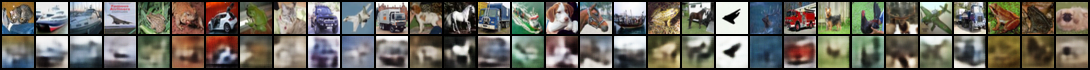

In [ ]:
# --- Step 3D: Quick visual check for last epoch (inline) ---
from IPython.display import Image, display
last_png = f"{samples_dir}/epoch_{epochs:03d}.png"
if os.path.exists(last_png):
    display(Image(filename=last_png))
else:
    # display latest available
    pngs = sorted([f for f in os.listdir(samples_dir) if f.endswith(".png")])
    if pngs:
        display(Image(filename=os.path.join(samples_dir, pngs[-1])))


# Step 4: Metrics (baseline)

### 4A) Load best checkpoint and set eval

In [ ]:
# Load best checkpoint (from Step 3) and set eval
best_path = f"./checkpoints/cifar_convvae_betaMAX{beta_max}_best.pt"
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["state_dict"])
model.eval()
print("Loaded:", best_path, "at epoch", ckpt.get("epoch", "?"))

Loaded: ./checkpoints/cifar_convvae_betaMAX1.0_best.pt at epoch 98


### 4B) Metric Helpers:
Latent entropy (closed-form for diagonal Gaussian, in nats)

Reconstruction variability (per-image pixel variance across K reconstructions)

Spectral slope α (fit log P(f) = c − α log f on reconstructions)


In [ ]:
import math
import numpy as np
import torch

# --- 4B-1: Latent entropy (nats) for q(z|x) with diagonal covariance ---
def latent_entropy(mu, logvar, base="nats"):
    # H = 0.5 * [ d*ln(2πe) + sum_i log σ_i^2 ]
    d = mu.size(1)
    const = 0.5 * d * math.log(2 * math.pi * math.e)
    H = const + 0.5 * logvar.sum(dim=1)
    if base == "bits":
        H = H / math.log(2.0)
    return H  # (B,)

# --- 4B-2: Reconstruction variability across K samples from q(z|x) ---
@torch.no_grad()
def reconstruction_variability(mu, logvar, K=10, batch_decode=256):
    # Sample z ~ q(z|x) K times and measure pixel variance of reconstructions
    B, D = mu.shape
    std = torch.exp(0.5 * logvar)
    eps = torch.randn(B, K, D, device=mu.device)
    z = mu.unsqueeze(1) + std.unsqueeze(1) * eps          # (B, K, D)
    z = z.reshape(-1, D)                                   # (B*K, D)

    # Decode in chunks to save memory
    xh_list = []
    for i in range(0, z.size(0), batch_decode):
        xh_list.append(model.decode(z[i:i+batch_decode]))
    xh = torch.cat(xh_list, dim=0)                         # (B*K, 3, 32, 32)
    xh = xh.view(B, K, 3, 32, 32)                          # (B, K, C, H, W)

    var_map = xh.var(dim=1, unbiased=False)                # (B, 3, 32, 32)
    var_scalar = var_map.mean(dim=(1,2,3))                 # (B,)
    return var_scalar

# --- 4B-3: Spectral slope (α) from 2D FFT radial power spectrum (deterministic recon via z=mu) ---
def _radial_profile(psd2d):
    H, W = psd2d.shape
    y, x = np.indices((H, W))
    cy, cx = (H - 1) / 2.0, (W - 1) / 2.0
    r = np.sqrt((x - cx)**2 + (y - cy)**2).astype(np.int32)
    tbin = np.bincount(r.ravel(), psd2d.ravel())
    nr = np.bincount(r.ravel())
    radial = tbin / np.maximum(nr, 1)
    return radial  # length ~ max radius

def _hann2d(h, w):
    return np.outer(np.hanning(h), np.hanning(w))

# --- Consistent fit band for spectral slope across datasets ---
F_LO, F_HI = 2, 14  # use radial bins [2..14]

@torch.no_grad()
def spectral_slope_alpha(xhat, fit_lo=F_LO, fit_hi=F_HI, eps=1e-8):
    B, C, H, W = xhat.shape
    alphas = np.zeros(B, dtype=np.float64)
    win = _hann2d(H, W)

    for i in range(B):
        # grayscale luminance (linear RGB -> Y)
        r, g, b = xhat[i,0].cpu().numpy(), xhat[i,1].cpu().numpy(), xhat[i,2].cpu().numpy()
        gray = 0.2126*r + 0.7152*g + 0.0722*b            # (32,32)
        gray = gray - gray.mean()
        gray = gray * win

        F = np.fft.fftshift(np.fft.fft2(gray))
        psd2d = (np.abs(F) ** 2).astype(np.float64)
        radial = _radial_profile(psd2d)                   # length ~ 45, but effective ~ 22 for 32x32

        # Fit slope on log-log, excluding DC (bin 0) and using mid-band range
        lo = max(fit_lo, 1)
        hi = min(fit_hi, len(radial) - 1)
        r = np.arange(len(radial), dtype=np.float64)
        xlog = np.log(r[lo:hi] + eps)
        ylog = np.log(radial[lo:hi] + eps)
        # linear fit y = a*x + b; α = -a
        a, b = np.polyfit(xlog, ylog, 1)
        alphas[i] = -a

    return alphas

In [ ]:
# --- Bootstrap 95% CI for the mean ---
import numpy as np

def mean_and_ci(a, n_boot=2000, alpha=0.05, seed=0):
    a = np.asarray(a, dtype=float)
    m = float(a.mean())
    rng = np.random.default_rng(seed)
    idx = rng.integers(0, len(a), size=(n_boot, len(a)))
    boots = a[idx].mean(axis=1)
    lo, hi = np.quantile(boots, [alpha/2, 1 - alpha/2])
    return m, float(lo), float(hi)


In [ ]:
# --- Helper: choose the right reconstruction for α ---
@torch.no_grad()
def x_for_alpha_from_posterior(mode, mu, logvar):

    if mode == "latent_noise":
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)
        return model.decode(z)
    else:
        return model.decode(mu)


In [ ]:
# CIFAR sanity: prints the fit band and a sample alpha mean
xb,_ = next(iter(test_loader)); xb = xb.to(device)
with torch.no_grad():
    mu, logvar = model.encode(xb)
x_for_alpha = x_for_alpha_from_posterior("baseline", mu, logvar)
a = spectral_slope_alpha(x_for_alpha)
print(f"CIFAR α: mean={a.mean():.3f}  band=[{F_LO},{F_HI}]  (len={len(a)})")


CIFAR α: mean=5.312  band=[2,14]  (len=128)


### 4C) Baseline Metric Runner

In [ ]:
from collections import defaultdict

@torch.no_grad()
def compute_baseline_metrics(loader, n_eval=2000, K_var=10):
    model.eval()
    results = defaultdict(list)
    counted = 0

    for xb, yb in loader:
        xb = xb.to(device)
        mu, logvar = model.encode(xb)

        # 1) Latent entropy (nats)
        H = latent_entropy(mu, logvar, base="nats")             # (B,)

        # 2) Reconstruction variability (K samples)
        rv = reconstruction_variability(mu, logvar, K=K_var)    # (B,)

        # 3) Spectral slope α from deterministic recon (z=mu)
        x_for_alpha = x_for_alpha_from_posterior("baseline", mu, logvar)
        alpha = spectral_slope_alpha(x_for_alpha)                     # (B,)

        # collect
        results["latent_entropy"].extend(H.detach().cpu().tolist())
        results["recon_var"].extend(rv.detach().cpu().tolist())
        results["spectral_alpha"].extend(alpha.tolist())
        results["labels"].extend(yb.tolist())

        counted += xb.size(0)
        if counted >= n_eval:
            break

    # convert to np arrays
    return {k: np.array(v) for k, v in results.items()}

def summarize_metrics(res, class_names=None):
    def m_s(x):
        return float(np.mean(x)), float(np.std(x))
    le_m, le_s = m_s(res["latent_entropy"])
    rv_m, rv_s = m_s(res["recon_var"])
    al_m, al_s = m_s(res["spectral_alpha"])

    print(f"Baseline (overall):")
    print(f"  Latent entropy (nats):  mean {le_m:.3f} ± {le_s:.3f}")
    print(f"  Recon variability:      mean {rv_m:.6f} ± {rv_s:.6f}")
    print(f"  Spectral slope α:       mean {al_m:.3f} ± {al_s:.3f}")

    if class_names is not None:
        print("\nPer-class means:")
        labels = res["labels"].astype(int)
        for c in range(len(class_names)):
            idx = (labels == c)
            if idx.sum() == 0:
                continue
            le_m = res["latent_entropy"][idx].mean()
            rv_m = res["recon_var"][idx].mean()
            al_m = res["spectral_alpha"][idx].mean()
            print(f"  {c:2d} {class_names[c]:>10s} | H {le_m:.3f}  RV {rv_m:.6f}  α {al_m:.3f}")


### 4D) Run Baseline Metrics

In [ ]:

res_base = compute_baseline_metrics(test_loader, n_eval=2000, K_var=10)
summarize_metrics(res_base, class_names=getattr(train_set, "classes", None))


Baseline (overall):
  Latent entropy (nats):  mean 113.464 ± 5.562
  Recon variability:      mean 0.007909 ± 0.001432
  Spectral slope α:       mean 5.313 ± 0.422

Per-class means:
   0   airplane | H 114.128  RV 0.007409  α 5.303
   1 automobile | H 110.533  RV 0.008439  α 5.337
   2       bird | H 115.825  RV 0.007471  α 5.281
   3        cat | H 112.506  RV 0.008231  α 5.346
   4       deer | H 117.258  RV 0.007351  α 5.211
   5        dog | H 111.806  RV 0.008365  α 5.432
   6       frog | H 116.927  RV 0.007529  α 5.197
   7      horse | H 111.199  RV 0.008217  α 5.388
   8       ship | H 113.911  RV 0.007711  α 5.315
   9      truck | H 110.237  RV 0.008404  α 5.339


# Step 5- Run Perturbations Sweeps + Comparing with Baseline

In [ ]:
# --- 5A. helpers to compare against your baseline means ---
import numpy as np

base_H  = float(np.mean(res_base["latent_entropy"]))
base_RV = float(np.mean(res_base["recon_var"]))
base_A  = float(np.mean(res_base["spectral_alpha"]))

def summarize_delta(tag, res):
    m = lambda a: float(np.mean(a))
    H, RV, A = m(res["latent_entropy"]), m(res["recon_var"]), m(res["spectral_alpha"])
    dH, dRV, dA = H-base_H, RV-base_RV, A-base_A
    print(f"{tag:>18s} | H {H:.3f} ({dH:+.3f})   RV {RV:.6f} ({dRV:+.6f})   α {A:.3f} ({dA:+.3f})")


In [ ]:
conditions_blur = [
    ("baseline", "baseline", None, "det"),
    ("blur σ=1.0", "input_blur", 1.0, "det"),
    ("blur σ=1.4", "input_blur", 1.4, "det"),
    ("blur σ=2.0", "input_blur", 2.0, "det"),
]
grid_blur, _ = recon_grid(conditions_blur, n=16, filename="./samples/recon_cascade_blur.png")
_ = difference_grid(conditions_blur[1:], n=16, filename="./samples/recon_cascade_blur_diffs.png")

rows=[]
for title,mode,param,amode in conditions_blur:
    m = metrics_for_batch(mode, param, xb_fixed[:16], alpha_mode="det")
    rows.append({"condition": title, **m})
pd.DataFrame(rows)

Saved: ./samples/recon_cascade_blur.png  | rows: ['original', 'baseline', 'blur σ=1.0', 'blur σ=1.4', 'blur σ=2.0']
Saved: ./samples/recon_cascade_blur_diffs.png  | rows (diff vs baseline): ['blur σ=1.0', 'blur σ=1.4', 'blur σ=2.0']


,condition,H_mean,H_std,RV_mean,RV_std,alpha_mean,alpha_std
0,baseline,112.860611,4.400607,0.008238,0.000903,5.287513,0.263669
1,blur σ=1.0,115.310684,4.043789,0.008180,0.000714,5.230508,0.375152
2,blur σ=1.4,116.150528,3.892910,0.007854,0.000866,5.182971,0.425449
3,blur σ=2.0,116.674324,3.800061,0.007800,0.000938,5.136408,0.456228


In [ ]:
import torchvision.transforms.functional as F_tv

import math
from collections import defaultdict

@torch.no_grad()
def run_metrics_with_perturbation(loader, n_eval=2000, K_var=10,
                                  mode="latent_noise",   # 'latent_noise' | 'beta_like' | 'input_blur' | 'baseline'
                                  param=1.0,
                                  alpha_mode="auto"):    # 'det' | 'sampled' | 'auto'

    model.eval()
    results = defaultdict(list)
    counted = 0

    for xb, yb in loader:
        xb = xb.to(device)

        # 1) Get posterior q(z|x) correctly first
        if mode == "input_blur":
            xb_proc = gaussian_blur_batch(xb, sigma=float(param))
            mu, logvar = model.encode(xb_proc)
        else:
            mu, logvar = model.encode(xb)

            if mode == "latent_noise":
                # scale posterior std: std' = s * std => logvar' = logvar + 2*ln(s)
                s = float(param)
                logvar = logvar + 2.0 * math.log(max(s, 1e-8))

            elif mode == "beta_like":
                # simulate stronger/weaker prior pull without retraining
                mu_shrink, std_shrink = param
                mu     = mu * float(mu_shrink)
                logvar = logvar - 2.0 * math.log(max(float(std_shrink), 1e-8))

            elif mode == "baseline":
                pass
            else:
                raise ValueError("mode must be 'latent_noise', 'beta_like', 'input_blur', or 'baseline'.")

        # 2) Metrics
        # Latent entropy (nats)
        H = latent_entropy(mu, logvar, base="nats")  # (B,)

        # Reconstruction variability across K samples
        RV = reconstruction_variability(mu, logvar, K=K_var)  # (B,)

        # Spectral slope α (choose det vs sampled)
        if alpha_mode == "auto":
            use_sample = (mode == "latent_noise")
        else:
            use_sample = (alpha_mode == "sampled")

        if use_sample:
            std = torch.exp(0.5 * logvar)
            z = mu + std * torch.randn_like(std)
            x_for_alpha = model.decode(z)
        else:
            x_for_alpha = model.decode(mu)

        A = spectral_slope_alpha(x_for_alpha)  # (B,)

        # 3) Collect
        results["latent_entropy"].extend(H.detach().cpu().tolist())
        results["recon_var"].extend(RV.detach().cpu().tolist())
        results["spectral_alpha"].extend(A.tolist())
        results["labels"].extend(yb.tolist())

        counted += xb.size(0)
        if counted >= n_eval:
            break

    return {k: np.array(v) for k, v in results.items()}


In [ ]:
# --- 5B. latent-noise sweep (scales posterior std) ---
noise_scales = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5]
res_noise = {}
for s in noise_scales:
    res_noise[s] = run_metrics_with_perturbation(
        test_loader, n_eval=1500, K_var=10,
        mode="latent_noise", param=s, alpha_mode="auto"  # sampled α for noise
    )
    summarize_delta(f"latent_noise x{s:.2f}", res_noise[s])


latent_noise x0.50 | H 24.732 (-88.733)   RV 0.001811 (-0.006098)   α 5.338 (+0.025)
latent_noise x0.75 | H 76.631 (-36.833)   RV 0.004209 (-0.003699)   α 5.341 (+0.027)
latent_noise x1.00 | H 113.455 (-0.010)   RV 0.007964 (+0.000056)   α 5.346 (+0.033)
latent_noise x1.25 | H 142.017 (+28.553)   RV 0.013247 (+0.005338)   α 5.327 (+0.014)
latent_noise x1.50 | H 165.354 (+51.890)   RV 0.020454 (+0.012545)   α 5.270 (-0.043)
latent_noise x2.00 | H 202.177 (+88.713)   RV 0.041923 (+0.034015)   α 5.135 (-0.179)
latent_noise x2.50 | H 230.740 (+117.275)   RV 0.072895 (+0.064986)   α 4.913 (-0.400)


In [ ]:
# --- 5C. beta-like prior pull (no retrain): shrink mu→0 and std→smaller ---

beta_like_settings = [
    (1.00, 1.00),  # baseline
    (0.85, 1.25),  # mild stronger-β
    (0.70, 1.60),  # medium
    (0.50, 2.00),  # strong
    (1.10, 0.85),  # weaker-β (for contrast)
]
res_beta = {}
for p in beta_like_settings:
    res_beta[p] = run_metrics_with_perturbation(
        test_loader, n_eval=1500, K_var=10,
        mode="beta_like", param=p, alpha_mode="det"   # deterministic α here
    )
    summarize_delta(f"beta_like {p}", res_beta[p])


beta_like (1.0, 1.0) | H 113.455 (-0.010)   RV 0.007922 (+0.000013)   α 5.314 (+0.001)
beta_like (0.85, 1.25) | H 84.892 (-28.572)   RV 0.004468 (-0.003441)   α 5.223 (-0.091)
beta_like (0.7, 1.6) | H 53.294 (-60.170)   RV 0.002350 (-0.005559)   α 4.965 (-0.348)
beta_like (0.5, 2.0) | H 24.732 (-88.733)   RV 0.001224 (-0.006685)   α 4.218 (-1.095)
beta_like (1.1, 0.85) | H 134.257 (+20.793)   RV 0.011849 (+0.003940)   α 5.314 (+0.000)


In [ ]:
import torchvision.transforms.functional as F_tv

def gaussian_blur_batch(x, sigma):
    """Applies Gaussian blur to a batch of images."""
    return F_tv.gaussian_blur(x, kernel_size=[5, 5], sigma=sigma)

In [ ]:
# --- 5D. input blur sweep (Gaussian σ in pixels, encode on blurred x) ---
blur_sigmas = [0.6, 1.0, 1.4, 2.0]
res_blur = {}
for sig in blur_sigmas:
    res_blur[sig] = run_metrics_with_perturbation(
        test_loader, n_eval=1500, K_var=10,
        mode="input_blur", param=sig, alpha_mode="det"
    )
    summarize_delta(f"blur σ={sig:.1f}", res_blur[sig])


        blur σ=0.6 | H 114.418 (+0.953)   RV 0.007795 (-0.000114)   α 5.311 (-0.002)
        blur σ=1.0 | H 115.623 (+2.158)   RV 0.007627 (-0.000282)   α 5.273 (-0.041)
        blur σ=1.4 | H 116.357 (+2.893)   RV 0.007506 (-0.000402)   α 5.222 (-0.091)
        blur σ=2.0 | H 116.816 (+3.352)   RV 0.007461 (-0.000447)   α 5.177 (-0.137)


In [ ]:
# Diagnostic: ΔH when scaling std by s should be d*ln(s)
import math, torch
model.eval()
xb,_ = next(iter(test_loader))
xb = xb.to(device)
with torch.no_grad():
    mu, logvar = model.encode(xb)

d = mu.size(1)
const = 0.5 * d * math.log(2*math.pi*math.e)
H0 = const + 0.5 * logvar.sum(dim=1)
for s in [0.5, 0.75, 1.0, 1.25, 1.5, 2.0]:
    logvar_s = logvar + 2.0 * math.log(s)
    Hs = const + 0.5 * logvar_s.sum(dim=1)
    print(f"s={s:>4}: theory ΔH={d*math.log(s):+.3f}  empirical ΔH={(Hs-H0).mean().item():+.3f}")


s= 0.5: theory ΔH=-88.723  empirical ΔH=-88.723
s=0.75: theory ΔH=-36.823  empirical ΔH=-36.823
s= 1.0: theory ΔH=+0.000  empirical ΔH=+0.000
s=1.25: theory ΔH=+28.562  empirical ΔH=+28.562
s= 1.5: theory ΔH=+51.900  empirical ΔH=+51.900
s= 2.0: theory ΔH=+88.723  empirical ΔH=+88.723


### Summarizer and CSV Writer

In [ ]:
# --- Summarise any results dict + export to CSV ---
import csv, os
from pathlib import Path

def _summarise_block(tag, res_dict, x_formatter=str, rows=None):
    if rows is None: rows = []
    for k, r in res_dict.items():
        Hm, Hlo, Hhi = mean_and_ci(r["latent_entropy"])
        RVm, RVlo, RVhi = mean_and_ci(r["recon_var"])
        Am, Alo, Ahi = mean_and_ci(r["spectral_alpha"])
        rows.append({
            "group": tag,
            "param": x_formatter(k),
            "H_mean": Hm, "H_lo": Hlo, "H_hi": Hhi,
            "RV_mean": RVm, "RV_lo": RVlo, "RV_hi": RVhi,
            "alpha_mean": Am, "alpha_lo": Alo, "alpha_hi": Ahi,
        })
    return rows

def export_all_results_csv(csv_path="./exports/cifar_metrics_summary.csv"):
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    rows = []
    # baseline
    if "res_base" in globals():
        rows = _summarise_block("baseline", {"baseline": res_base}, x_formatter=lambda k: k, rows=rows)
    # latent noise
    if "res_noise" in globals() and len(res_noise):
        rows = _summarise_block("latent_noise", res_noise, x_formatter=lambda k: f"{float(k):.2f}", rows=rows)
    # beta-like
    if "res_beta" in globals() and len(res_beta):
        rows = _summarise_block("beta_like", res_beta, x_formatter=lambda k: f"mu*{k[0]:.2f}_std/{k[1]:.2f}", rows=rows)
    # input blur
    if "res_blur" in globals() and len(res_blur):
        rows = _summarise_block("input_blur", res_blur, x_formatter=lambda k: f"{float(k):.2f}", rows=rows)

    if not rows:
        print("No results found to export. Run your metric sweeps first.")
        return None

    keys = list(rows[0].keys())
    with open(csv_path, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=keys)
        w.writeheader(); w.writerows(rows)
    print(f"✓ Saved: {csv_path}")
    return csv_path


export_all_results_csv("./exports/cifar10_metrics_summary.csv")
os.makedirs("./exports", exist_ok=True)
if "df_noise_panel" in globals():
    df_noise_panel.to_csv("./exports/cifar10_noise_panel_metrics.csv", index=False)
    print("✓ Saved panel metrics: ./exports/cifar10_noise_panel_metrics.csv")



✓ Saved: ./exports/cifar10_metrics_summary.csv
✓ Saved panel metrics: ./exports/cifar10_noise_panel_metrics.csv


# Ssualisations

### 1) Baseline Histograms       

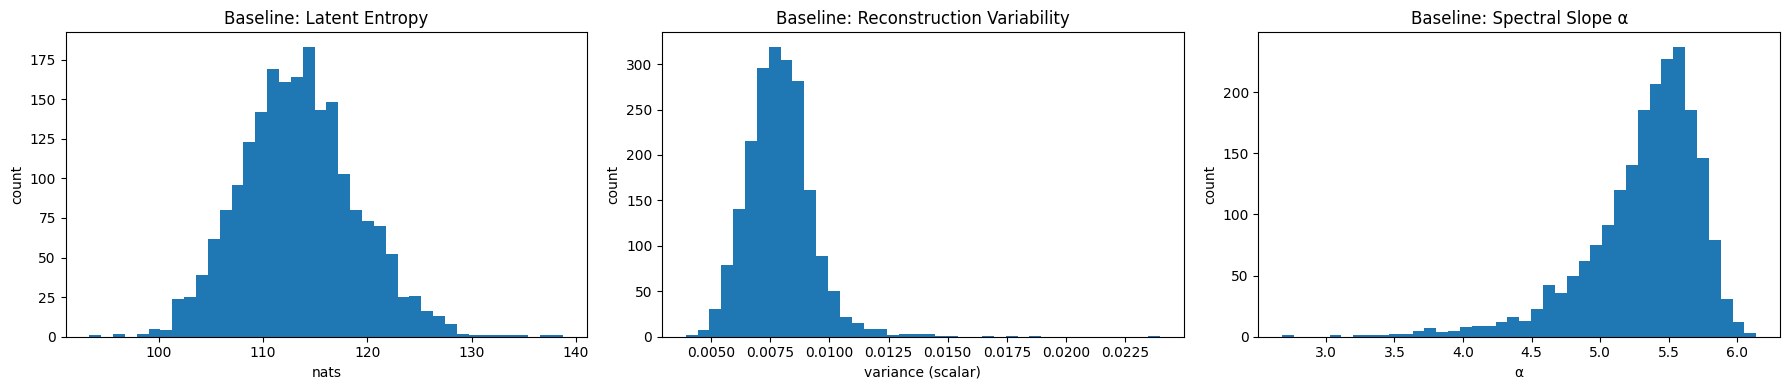

In [ ]:
import numpy as np, matplotlib.pyplot as plt

def hist_plot(ax, data, title, xlabel):
    ax.hist(np.asarray(data), bins=40)
    ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel("count")

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

hist_plot(axes[0], res_base["latent_entropy"], "Baseline: Latent Entropy", "nats")
hist_plot(axes[1], res_base["recon_var"],      "Baseline: Reconstruction Variability", "variance (scalar)")
hist_plot(axes[2], res_base["spectral_alpha"], "Baseline: Spectral Slope α", "α")

plt.tight_layout(); plt.show()

### 2) Helper Mean + 95% CI and generic line plot

In [ ]:
import numpy as np, matplotlib.pyplot as plt

def mean_and_ci(a, n_boot=2000, alpha=0.05, seed=0):
    a = np.asarray(a)
    m = float(a.mean())
    rng = np.random.default_rng(seed)
    idx = rng.integers(0, len(a), size=(n_boot, len(a)))
    boots = a[idx].mean(axis=1)
    lo, hi = np.quantile(boots, [alpha/2, 1-alpha/2])
    return m, float(lo), float(hi)

def line_with_ci(x, y_means, y_los, y_his, title, xlabel, ylabel, xticklabels=None):
    plt.figure(figsize=(6,4))
    plt.plot(x, y_means, marker="o")
    plt.fill_between(x, y_los, y_his, alpha=0.2)
    if xticklabels is not None:
        plt.xticks(x, xticklabels, rotation=0)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.tight_layout(); plt.show()


### 3) Latent Noise Sweep Plots

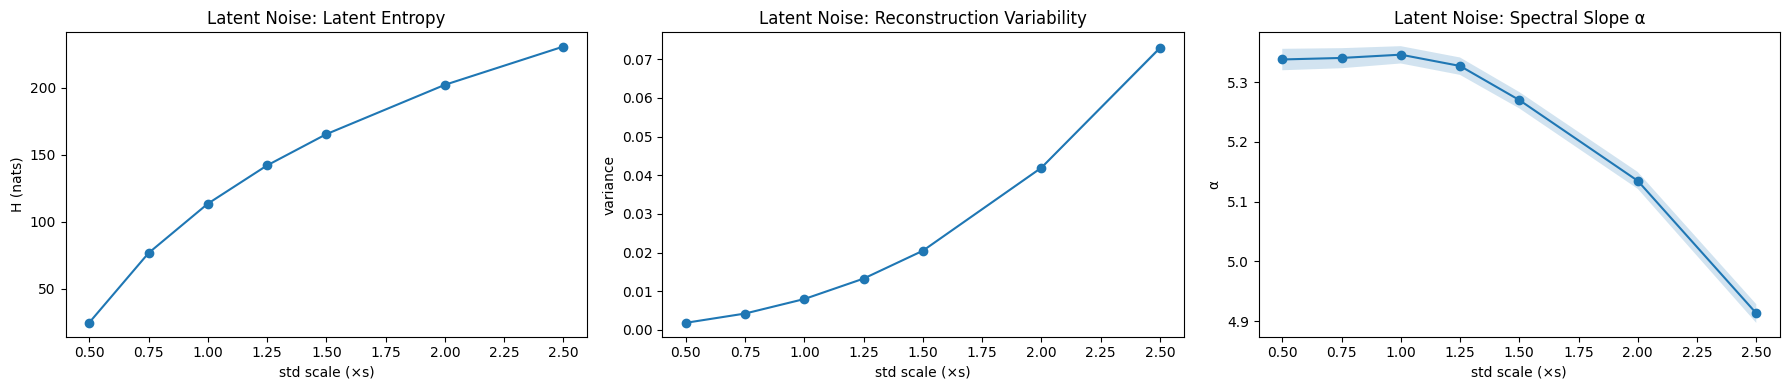

In [ ]:
# assumes: res_noise = {scale: metrics_dict}
scales = sorted(res_noise.keys(), key=float)
x = [float(s) for s in scales]

Hm, Hlo, Hhi = [], [], []
RVm, RVlo, RVhi = [], [], []
Am, Alo, Ahi = [], [], []
for s in scales:
    m, lo, hi = mean_and_ci(res_noise[s]["latent_entropy"]); Hm.append(m); Hlo.append(lo); Hhi.append(hi)
    m, lo, hi = mean_and_ci(res_noise[s]["recon_var"]);      RVm.append(m); RVlo.append(lo); RVhi.append(hi)
    m, lo, hi = mean_and_ci(res_noise[s]["spectral_alpha"]); Am.append(m); Alo.append(lo); Ahi.append(hi)

# Plotting side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 4)) # 1 row, 3 columns

# Latent Entropy plot
axes[0].plot(x, Hm, marker="o")
axes[0].fill_between(x, Hlo, Hhi, alpha=0.2)
axes[0].set_title("Latent Noise: Latent Entropy"); axes[0].set_xlabel("std scale (×s)"); axes[0].set_ylabel("H (nats)")

# Reconstruction Variability plot
axes[1].plot(x, RVm, marker="o")
axes[1].fill_between(x, RVlo, RVhi, alpha=0.2)
axes[1].set_title("Latent Noise: Reconstruction Variability"); axes[1].set_xlabel("std scale (×s)"); axes[1].set_ylabel("variance")

# Spectral Slope α plot
axes[2].plot(x, Am, marker="o")
axes[2].fill_between(x, Alo, Ahi, alpha=0.2)
axes[2].set_title("Latent Noise: Spectral Slope α"); axes[2].set_xlabel("std scale (×s)"); axes[2].set_ylabel("α")

plt.tight_layout()
plt.show()

### 4) β-like sweep

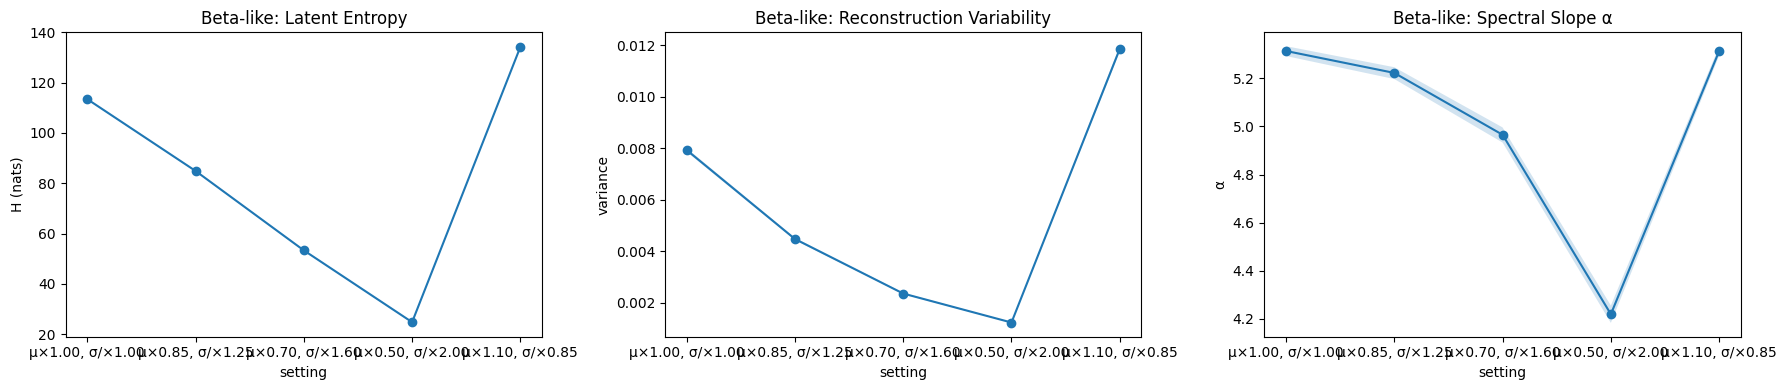

In [ ]:
# assumes: res_beta = {(mu_shrink, std_shrink): metrics_dict}
beta_keys = list(res_beta.keys())
x = list(range(len(beta_keys)))
tick = [f"μ×{k[0]:.2f}, σ/×{k[1]:.2f}" for k in beta_keys]

Hm, Hlo, Hhi = [], [], []
RVm, RVlo, RVhi = [], [], []
Am, Alo, Ahi = [], [], []
for k in beta_keys:
    m, lo, hi = mean_and_ci(res_beta[k]["latent_entropy"]); Hm.append(m); Hlo.append(lo); Hhi.append(hi)
    m, lo, hi = mean_and_ci(res_beta[k]["recon_var"]);      RVm.append(m); RVlo.append(lo); RVhi.append(hi)
    m, lo, hi = mean_and_ci(res_beta[k]["spectral_alpha"]); Am.append(m); Alo.append(lo); Ahi.append(hi)

fig, axes = plt.subplots(1, 3, figsize=(18, 4)) # 1 row, 3 columns

# Latent Entropy plot
axes[0].plot(x, Hm, marker="o")
axes[0].fill_between(x, Hlo, Hhi, alpha=0.2)
axes[0].set_title("Beta-like: Latent Entropy"); axes[0].set_xlabel("setting"); axes[0].set_ylabel("H (nats)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(tick, rotation=0)


# Reconstruction Variability plot
axes[1].plot(x, RVm, marker="o")
axes[1].fill_between(x, RVlo, RVhi, alpha=0.2)
axes[1].set_title("Beta-like: Reconstruction Variability"); axes[1].set_xlabel("setting"); axes[1].set_ylabel("variance")
axes[1].set_xticks(x)
axes[1].set_xticklabels(tick, rotation=0)


# Spectral Slope α plot
axes[2].plot(x, Am, marker="o")
axes[2].fill_between(x, Alo, Ahi, alpha=0.2)
axes[2].set_title("Beta-like: Spectral Slope α"); axes[2].set_xlabel("setting"); axes[2].set_ylabel("α")
axes[2].set_xticks(x)
axes[2].set_xticklabels(tick, rotation=0)


plt.tight_layout()
plt.show()

### 5) Input-Blur Sweep

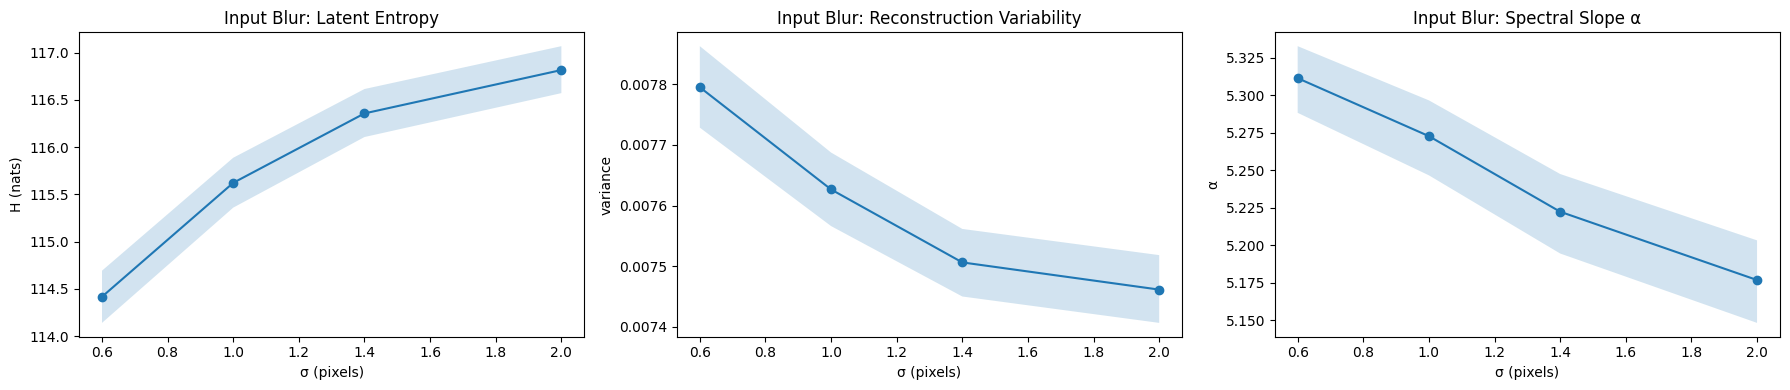

In [ ]:
# assumes: res_blur = {sigma: metrics_dict}
sigmas = sorted(res_blur.keys(), key=float)
x = [float(s) for s in sigmas]

Hm, Hlo, Hhi = [], [], []
RVm, RVlo, RVhi = [], [], []
Am, Alo, Ahi = [], [], []
for s in sigmas:
    m, lo, hi = mean_and_ci(res_blur[s]["latent_entropy"]); Hm.append(m); Hlo.append(lo); Hhi.append(hi)
    m, lo, hi = mean_and_ci(res_blur[s]["recon_var"]);      RVm.append(m); RVlo.append(lo); RVhi.append(hi)
    m, lo, hi = mean_and_ci(res_blur[s]["spectral_alpha"]); Am.append(m); Alo.append(lo); Ahi.append(hi)

fig, axes = plt.subplots(1, 3, figsize=(18, 4)) # 1 row, 3 columns

# Latent Entropy plot
axes[0].plot(x, Hm, marker="o")
axes[0].fill_between(x, Hlo, Hhi, alpha=0.2)
axes[0].set_title("Input Blur: Latent Entropy"); axes[0].set_xlabel("σ (pixels)"); axes[0].set_ylabel("H (nats)")

# Reconstruction Variability plot
axes[1].plot(x, RVm, marker="o")
axes[1].fill_between(x, RVlo, RVhi, alpha=0.2)
axes[1].set_title("Input Blur: Reconstruction Variability"); axes[1].set_xlabel("σ (pixels)"); axes[1].set_ylabel("variance")

# Spectral Slope α plot
axes[2].plot(x, Am, marker="o")
axes[2].fill_between(x, Alo, Ahi, alpha=0.2)
axes[2].set_title("Input Blur: Spectral Slope α"); axes[2].set_xlabel("σ (pixels)"); axes[2].set_ylabel("α")

plt.tight_layout()
plt.show()

# Step 7: Reconstructions Grids: Baseline - Perturbations

### 7A) Fixed Test batch to Reuse across all conditions

In [ ]:
import math, torch
from torchvision.utils import make_grid, save_image

model.eval()
xb_fixed, yb_fixed = next(iter(test_loader))   # (B,3,32,32) in [-1,1]
xb_fixed = xb_fixed.to(device)

def to_disp(x):  # [-1,1] -> [0,1] for display
    return (x.clamp(-1,1) + 1)/2


### 7B) Recon under a given 'mode'

In [ ]:
import torch.nn.functional as F
import math

@torch.no_grad()
def recon_under(mode="baseline", param=None, x=None, sample_for_noise=True):
    """
    mode: 'baseline' | 'latent_noise' | 'beta_like' | 'input_blur'
    param:
      - latent_noise: float scale s (std' = s*std)
      - beta_like: tuple (mu_shrink, std_shrink) where std' = std / std_shrink
      - input_blur: float sigma in pixels
    """
    if x is None:
        x = xb_fixed

    if mode == "input_blur":
        x_in = gaussian_blur_batch(x, sigma=float(param))
        mu, logvar = model.encode(x_in)
    else:
        x_in = x
        mu, logvar = model.encode(x_in)
        if mode == "latent_noise":
            s = float(param)
            logvar = logvar + 2.0 * math.log(max(s, 1e-8))
        elif mode == "beta_like":
            mu_shrink, std_shrink = param
            mu = mu * float(mu_shrink)
            logvar = logvar - 2.0 * math.log(max(float(std_shrink), 1e-8))
        elif mode == "baseline":
            pass
        else:
            raise ValueError("Unknown mode")

    # Deterministic vs sampled decode
    if mode == "latent_noise" and sample_for_noise:
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)
    else:
        z = mu

    x_hat = model.decode(z)  # (B,3,32,32) in [-1,1]
    return x_in, x_hat


In [ ]:
conditions = [
    ("baseline", "baseline", None, "det"),
    ("latent x1.5", "latent_noise", 1.5, "auto"),
    ("beta μ×0.7 σ/×1.6", "beta_like", (0.7, 1.6), "det"),
    ("blur σ=1.4", "input_blur", 1.4, "det"),
]
grid, titles = recon_grid(conditions, n=16, filename="./samples/recon_compare_main.png")

Saved: ./samples/recon_compare_main.png  | rows: ['original', 'baseline', 'latent x1.5', 'beta μ×0.7 σ/×1.6', 'blur σ=1.4']


Recon Cascade across noise levels (same images, same layout)


In [ ]:
# ---- Fixed comparison batch & helpers (run this first) ----
import torch
from torchvision.utils import make_grid, save_image

model.eval()

# 1) create a fixed test batch to reuse everywhere
xb_fixed, yb_fixed = next(iter(test_loader))   # (B,3,32,32) in [-1,1]
xb_fixed = xb_fixed.to(device)

def to_disp(x):  # [-1,1] -> [0,1]
    return (x.clamp(-1,1) + 1)/2


 ### 7C) Build a side-by-side grid: originals, baseline recon, and each perturbation

In [ ]:
import numpy as np

def recon_grid(conditions, n=16, filename="./samples/recon_compare.png"):

    # slice a stable subset
    x = xb_fixed[:n]

    # row 0: originals
    rows = [to_disp(x).cpu()]
    titles = ["original"]

    # remaining rows: recons
    for title, mode, param, amode in conditions:
        x_in, x_hat = recon_under(mode=mode, param=param, x=x)
        rows.append(to_disp(x_hat).cpu())
        titles.append(title)

    # stack rows into a single grid
    # (num_rows * n, 3, 32, 32) -> grid nrow=n
    tiles = torch.cat(rows, dim=0)
    grid = make_grid(tiles, nrow=n, pad_value=0.5)

    save_image(grid, filename)
    print(f"Saved: {filename}  | rows: {titles}")
    return grid, titles

# Step 8 - Difference Maps (Where did Recon change ?)

In [ ]:
from torchvision.utils import make_grid, save_image

@torch.no_grad()
def difference_grid(conditions, n=16, filename="./samples/recon_diffs.png"):
    x = xb_fixed[:n]
    _, xhat_base = recon_under(mode="baseline", x=x)
    base = xhat_base

    rows = []
    titles = []
    for title, mode, param, amode in conditions: # Modified to unpack 4 values
        _, xhat = recon_under(mode=mode, param=param, x=x)
        diff = (xhat - base).abs()                 # [-2,2] space
        diff = diff / (diff.max().clamp_min(1e-8)) # normalise to [0,1] range per-batch
        rows.append(diff.cpu())
        titles.append(title)

    tiles = torch.cat(rows, dim=0)
    grid = make_grid(tiles, nrow=n, pad_value=0.5)
    save_image(grid, filename)
    print(f"Saved: {filename}  | rows (diff vs baseline): {titles}")
    return grid, titles

conditions = [
    ("baseline", "baseline", None, "det"),
    ("latent x1.5", "latent_noise", 1.5, "auto"),
    ("beta μ×0.7 σ/×1.6", "beta_like", (0.7, 1.6), "det"),
    ("blur σ=1.4", "input_blur", 1.4, "det"),
]

_ = difference_grid(conditions[1:], n=16, filename="./samples/recon_compare_diffs.png")

Saved: ./samples/recon_compare_diffs.png  | rows (diff vs baseline): ['latent x1.5', 'beta μ×0.7 σ/×1.6', 'blur σ=1.4']


In [ ]:
# choose the noise scales you want to showcase
noise_scales_show = [0.75, 1.25, 1.5, 2.0, 2.5]  # add/remove as you like

conditions_noise = [("baseline", "baseline", None, "det")]
conditions_noise += [(f"latent x{s}", "latent_noise", float(s), "auto") for s in noise_scales_show]


grid, titles = recon_grid(conditions_noise, n=16, filename="./samples/recon_cascade_noise.png")


_ = difference_grid(conditions_noise[1:], n=16, filename="./samples/recon_cascade_noise_diffs.png")

Saved: ./samples/recon_cascade_noise.png  | rows: ['original', 'baseline', 'latent x0.75', 'latent x1.25', 'latent x1.5', 'latent x2.0', 'latent x2.5']
Saved: ./samples/recon_cascade_noise_diffs.png  | rows (diff vs baseline): ['latent x0.75', 'latent x1.25', 'latent x1.5', 'latent x2.0', 'latent x2.5']


In [ ]:
# === Step 9 — per-row metrics for the SAME images used in your grid ===
import numpy as np
import pandas as pd

def metrics_for_batch(mode, param=None, x=None, K_var=20, alpha_mode="auto"):
    x = xb_fixed[:16] if x is None else x  # match your grid size
    with torch.no_grad():
        if mode == "input_blur":
            x_in = gaussian_blur_batch(x, sigma=float(param))
            mu, logvar = model.encode(x_in)
        else:
            x_in = x
            mu, logvar = model.encode(x_in)
            if mode == "latent_noise":
                s = float(param)
                logvar = logvar + 2.0 * math.log(max(s, 1e-8))
            elif mode == "beta_like":
                mu_shrink, std_shrink = param
                mu     = mu * float(mu_shrink)
                logvar = logvar - 2.0 * math.log(max(float(std_shrink), 1e-8))

        # 1) latent entropy (nats)
        H = latent_entropy(mu, logvar, base="nats").cpu().numpy()

        # 2) reconstruction variability (K samples)
        RV = reconstruction_variability(mu, logvar, K=K_var).cpu().numpy()

        # 3) spectral slope α
        if alpha_mode == "auto":
            use_sample = (mode == "latent_noise")
        else:
            use_sample = (alpha_mode == "sampled")
        if use_sample:
            std = torch.exp(0.5 * logvar)
            z = mu + std * torch.randn_like(std)
            x_for_alpha = model.decode(z)
        else:
            x_for_alpha = model.decode(mu)
        A = spectral_slope_alpha(x_for_alpha)

    return {
        "H_mean": float(np.mean(H)), "H_std": float(np.std(H)),
        "RV_mean": float(np.mean(RV)), "RV_std": float(np.std(RV)),
        "alpha_mean": float(np.mean(A)), "alpha_std": float(np.std(A)),
    }

conditions = [
    ("baseline", "baseline", None, "det"),
    ("latent x1.5", "latent_noise", 1.5, "auto"),
    ("beta μ×0.7 σ/×1.6", "beta_like", (0.7,1.6), "det"),
    ("blur σ=1.4", "input_blur", 1.4, "det"),
]

rows = []
for title, mode, param, amode in conditions:
    m = metrics_for_batch(mode, param, xb_fixed[:16], alpha_mode=amode)
    rows.append({"condition": title, **m})

df_rows = pd.DataFrame(rows)
df_rows


,condition,H_mean,H_std,RV_mean,RV_std,alpha_mean,alpha_std
0,baseline,112.860611,4.400607,0.008482,0.000932,5.287513,0.263669
1,latent x1.5,164.760132,4.400608,0.021911,0.001687,5.229912,0.277236
2,beta μ×0.7 σ/×1.6,52.700134,4.400609,0.002408,0.000408,4.903501,0.602381
3,blur σ=1.4,116.150528,3.892910,0.007959,0.000883,5.182971,0.425449


In [ ]:
conditions_beta = [
    ("baseline", "baseline", None, "det"),
    ("β-like μ×0.85 σ/×1.25", "beta_like", (0.85, 1.25), "det"),
    ("β-like μ×0.70 σ/×1.60", "beta_like", (0.70, 1.60), "det"),
]
grid_b, _ = recon_grid(conditions_beta, n=16, filename="./samples/recon_cascade_beta.png")
_ = difference_grid(conditions_beta[1:], n=16, filename="./samples/recon_cascade_beta_diffs.png")

# per-row metrics (for caption)
import pandas as pd
rows=[]
for title,mode,param,amode in conditions_beta:
    m = metrics_for_batch(mode, param, xb_fixed[:16], alpha_mode="det")
    rows.append({"condition": title, **m})
pd.DataFrame(rows)

Saved: ./samples/recon_cascade_beta.png  | rows: ['original', 'baseline', 'β-like μ×0.85 σ/×1.25', 'β-like μ×0.70 σ/×1.60']
Saved: ./samples/recon_cascade_beta_diffs.png  | rows (diff vs baseline): ['β-like μ×0.85 σ/×1.25', 'β-like μ×0.70 σ/×1.60']


,condition,H_mean,H_std,RV_mean,RV_std,alpha_mean,alpha_std
0,baseline,112.860611,4.400607,0.008589,0.001185,5.287513,0.263669
1,β-like μ×0.85 σ/×1.25,84.298233,4.400606,0.004717,0.000677,5.173083,0.398750
2,β-like μ×0.70 σ/×1.60,52.700134,4.400609,0.002400,0.000447,4.903501,0.602381


In [ ]:
#---------Tiny Metric Table------------
import pandas as pd

rows = []
for title, mode, param, amode in conditions_noise:
    m = metrics_for_batch(mode, param, xb_fixed[:16], alpha_mode=("auto" if mode=="latent_noise" else "det"))
    rows.append({"condition": title, **m})
df_noise_panel = pd.DataFrame(rows)
df_noise_panel

,condition,H_mean,H_std,RV_mean,RV_std,alpha_mean,alpha_std
0,baseline,112.860611,4.400607,0.008404,0.001027,5.287513,0.263669
1,latent x0.75,76.037300,4.400607,0.004498,0.000578,5.323825,0.240285
2,latent x1.25,141.422974,4.400609,0.013952,0.001220,5.205115,0.267370
3,latent x1.5,164.760132,4.400608,0.021799,0.002091,5.204270,0.223815
4,latent x2.0,201.583435,4.400608,0.044804,0.004178,5.124611,0.258867
5,latent x2.5,230.145813,4.400607,0.073941,0.007373,4.895179,0.332813


Saved: ./samples/recon_compare_main.png  | rows: ['original', 'baseline', 'latent x1.5', 'beta μ×0.7 σ/×1.6', 'blur σ=1.4']


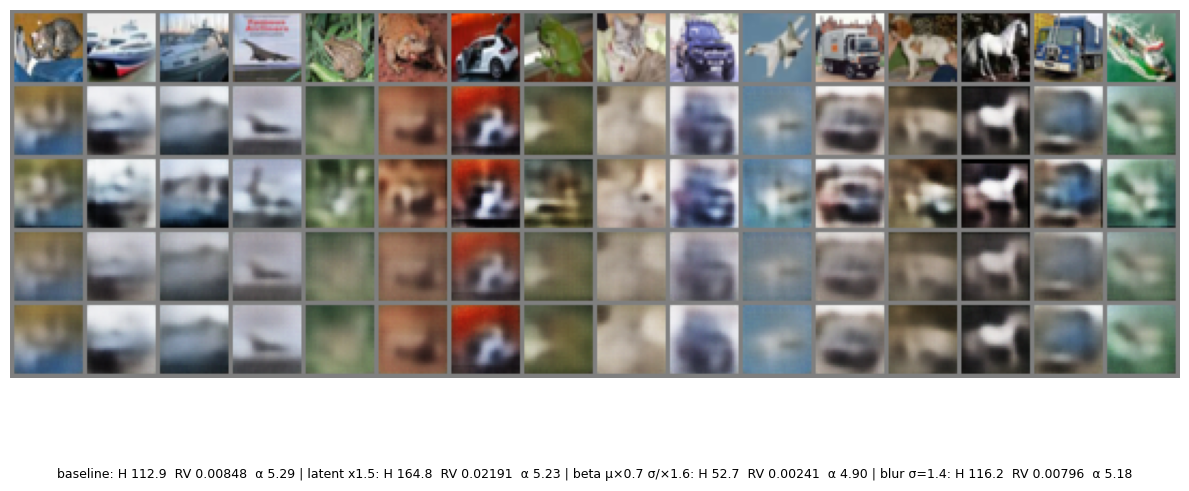

Saved annotated grid.


In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
def save_grid_with_caption(filename, grid_tensor, df_rows):
    plt.figure(figsize=(12, 6))
    plt.imshow(np.transpose(grid_tensor.numpy(), (1,2,0)))
    plt.axis("off")
    # caption: one line with means
    lines = [f"{r['condition']}: H {r['H_mean']:.1f}  RV {r['RV_mean']:.5f}  α {r['alpha_mean']:.2f}"
             for _, r in df_rows.iterrows()]
    caption = " | ".join(lines)
    plt.suptitle(caption, y=0.02, fontsize=9)
    plt.tight_layout()
    plt.savefig(filename, bbox_inches="tight", dpi=200)
    plt.show()

grid, titles = recon_grid(conditions, n=16, filename="./samples/recon_compare_main.png")
save_grid_with_caption("./samples/recon_compare_main_annotated.png", grid.cpu(), df_rows)
print("Saved annotated grid.")

Sanity Check on Entropy oddity

In [ ]:
import math
model.eval()
xb,_ = next(iter(test_loader))
xb = xb.to(device)
with torch.no_grad():
    mu, logvar = model.encode(xb)
d = mu.size(1)
const = 0.5 * d * math.log(2*math.pi*math.e)
H0 = const + 0.5 * logvar.sum(1)
for s in [0.5, 1.0, 2.0]:
    Hs = const + 0.5 * (logvar + 2.0*math.log(s)).sum(1)
    print(f"s={s}: theory ΔH={d*math.log(s):+.1f}  empirical ΔH={(Hs-H0).mean().item():+.1f}")


s=0.5: theory ΔH=-88.7  empirical ΔH=-88.7
s=1.0: theory ΔH=+0.0  empirical ΔH=+0.0
s=2.0: theory ΔH=+88.7  empirical ΔH=+88.7
